# Attention

An attention is a function of Query($Q$), and a squence of [Keys ($K$), Values($V$)] pairs. The intuition of attention mechanism is, given a query, it tries to take a simmilarity over the keys in a sense producing the how much attention to give to the keys. The attention or the simmilarity calculated between the $Q$ and $K$ is first scaled using the softmax and normalized by $d$ the dimension of the vector $Q$.

This scaled attention is used as weights for averaging over the $V$.

$$
\begin{align}
\text{Attention}(Q, K, V) = \text{softmax}(\frac{Q \cdot K^{T}}{\sqrt{d}}) \odot V
\end{align}
$$

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d):
        super().__init__()

        # Scaling w.r.t dimension
        self.normalization_factor = d**0.5

    def forward(self, q, k, v, mask = None):
        #assert mask.shape == ()
        # q is of shape [(num_q) x d] and k is of shape [SEQ_LEN x d]
        unnormalized = F.softmax(torch.matmul(q, torch.transpose(k, -2, -1)), dim = -1)
        normalized = unnormalized / self.normalization_factor # shape [(num_q) x (seq_len)]
        if mask is not None:
            normalized = torch.mul(mask, normalized)
        
        # normalized attention should be of shape [(num_q) X SEQ_LEN]
        # v is of shape [SEQ_LEN x d]
        attention_value = torch.matmul(normalized, v) # shape [num_q x d]
        return attention_value, normalized

In [3]:
d = 128
seq_len = 16
batch_size = 4

q = torch.rand(size=(batch_size, seq_len, d))
k = torch.rand(size=(batch_size, seq_len,d))
v = k

attention_layer = ScaledDotProductAttention(d)
attention, weights = attention_layer(q,k,v)

# [Batch_size x seq_len x d]
print("Shape of the attention values: ", attention.shape)

Shape of the attention values:  torch.Size([4, 16, 128])


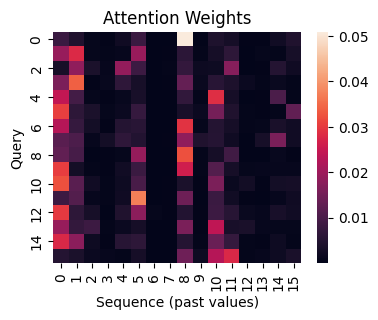

In [4]:
plt.figure(figsize=(4,3))
ax = sns.heatmap(weights.numpy()[1])
_ = ax.set(ylabel = "Query", 
           xlabel = "Sequence (past values)", 
           title  = "Attention Weights")

In [5]:
class Attention(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super().__init__()

        # Transforming the input to linear weights
        self.query_weights = nn.Linear(input_dim, embedding_dim)
        self.key_weights = nn.Linear(input_dim, embedding_dim)
        self.value_weights = nn.Linear(input_dim, embedding_dim)

        self.scaled_attention = ScaledDotProductAttention(embedding_dim)

    def forward(self, x):
        # x is of shape [batch_size, seq_len, input_dim]
        q = self.query_weights(x) # [batch_size, seq_len, embedding_dim]
        k = self.key_weights(x) 
        v = self.value_weights(x)

        # attention will be of shape [batch_size, seq_len, embedding_dim]
        attention, attention_weights = self.scaled_attention(q, k, v)
        return attention, attention_weights

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, num_heads, embedding_dim, output_dim):
        super().__init__()
        assert (output_dim % num_heads == 0), "output dim must be divisible by num heads"
        
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim // num_heads
        self.multihead_attention = [(Attention(input_dim, self.embedding_dim)) for _ in range(num_heads)]

        self.output_projection = nn.Linear(embedding_dim, output_dim)
    
    def forward(self, x):
        attention_list, weights_list = [], []
        for attention_head in self.multihead_attention:
            attention, attention_weights = attention_head(x)
            attention_list.append(attention)
            weights_list.append(attention_weights.unsqueeze(dim = 1))
        
        attention = torch.cat(attention_list, dim = -1)
        weights_list = torch.cat(weights_list, dim = 1)

        attention = self.output_projection(attention)
        return attention, weights_list

In [19]:
batch_size = 8
seq_len = 10

input_dim = 128
embedding_dim = 128
output_dim = 128
num_heads = 4

In [20]:
x = torch.rand(size=(batch_size, seq_len, input_dim))

In [21]:
multihead_attention = MultiHeadAttention(input_dim, 
                                         num_heads, 
                                         embedding_dim,
                                         output_dim)

In [22]:
attention, weights = multihead_attention(x)

The attention that comes out is of shape $[\text{batch size}, \text{seq len}, \text{projection dim}]$  
The attention weights that comes out is of shape $[\text{batch size},\text{num heads},\text{seq len}, \text{seq len}]$

In [23]:
print("Shape of the attention \t:", attention.shape)
print("Shape of the weights \t:", weights.shape)

Shape of the attention 	: torch.Size([8, 10, 128])
Shape of the weights 	: torch.Size([8, 4, 10, 10])
